In [1]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import wget
#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam,AdamW, RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#helper function
url =  'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [3]:
spices_data = 'D:\ML\Spices_Clasification_update'
walk_through_dir(spices_data)

There are 26 directories and 0 images in 'D:\ML\Spices_Clasification_update'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\adas'.
There are 0 directories and 195 images in 'D:\ML\Spices_Clasification_update\andaliman'.
There are 0 directories and 201 images in 'D:\ML\Spices_Clasification_update\asam_jawa'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\biji_ketumbar'.
There are 0 directories and 136 images in 'D:\ML\Spices_Clasification_update\bukan_rempah'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\bunga_lawang'.
There are 0 directories and 202 images in 'D:\ML\Spices_Clasification_update\cengkeh'.
There are 0 directories and 215 images in 'D:\ML\Spices_Clasification_update\daun_ketumbar'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\daun_salam'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\jahe'.
There are 0 directories and 1

In [4]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

Filepath        Label
0      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
1      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
2      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
3      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
4      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
...                                                  ...          ...
10285  D:\ML\Spices_Clasification_update\kayu manis\I...   kayu manis
10286  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10287  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10288  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri
10289  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri

[10290 rows x 2 columns]

**VISUALIZE THE DATASET**

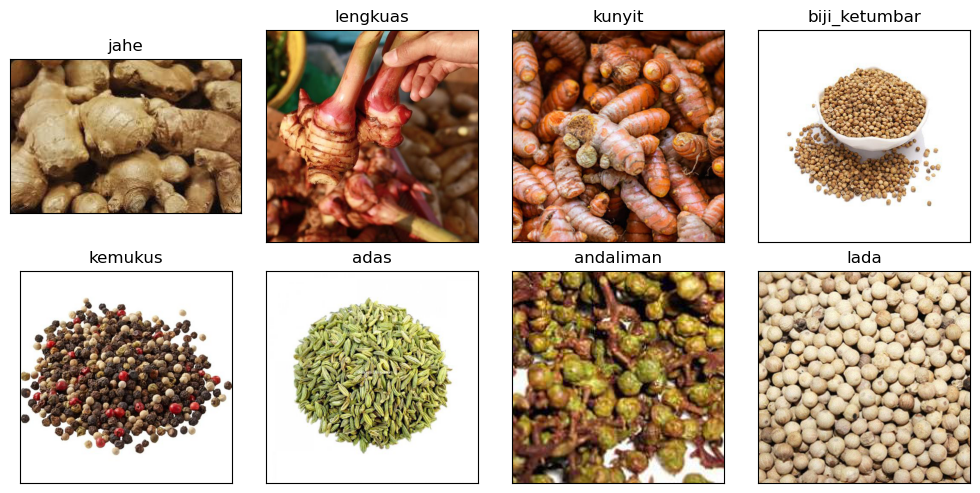

In [7]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [8]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=1)
training_dataset, validation_dataset = train_test_split(training_dataset,test_size=0.2, shuffle=True, random_state=1)

In [9]:
train_generator = ImageDataGenerator(
    rescale=(1.0/255),
    rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.3,  # Fraction of total width for random horizontal shift
    height_shift_range=0.3, # Fraction of total height for random vertical shift
    shear_range=0.3,        # Shear intensity (shear angle in radians)
    zoom_range=0.3,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'
)

validation_generator = ImageDataGenerator(
   rescale=(1.0/255)
)

test_generator = ImageDataGenerator(
    rescale=(1.0/255.0)
)

In [10]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = validation_generator.flow_from_dataframe(
dataframe = validation_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42)

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 7408 validated image filenames belonging to 26 classes.
Found 1853 validated image filenames belonging to 26 classes.
Found 1029 validated image filenames belonging to 26 classes.


In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
], name="data_augmentation")

In [12]:
input_shape = (224, 224, 3)

# Create Inception model
Base_Model = InceptionV3(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
# Freeze the layers of the pre-trained model
for layer in Base_Model.layers[-14:]:
    layer.trainable = True
# # Find the index of the layer you want to start training from
# start_layer_name = 'conv5_block2_3_conv'
# start_layer_index = None
# for i, layer in enumerate(Base_Model.layers):
#     if layer.name == start_layer_name:
#         start_layer_index = i
#         break

# # Make only the specified layers trainable
# for layer in Base_Model.layers[:start_layer_index]:
#     layer.trainable = False

# Display the summary of the model
Base_Model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [13]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [14]:
print(Base_Model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [15]:
def build_model(base_model, num_classes):
    # Resize and rescale input images
    x = resize_and_rescale(base_model.input)
    
    # Apply data augmentation
    x = augmented(x)
    
    # Get the output from the base model
    base_model_output = base_model.output
    
    # Add your custom layers
    x = GlobalAveragePooling2D()(base_model_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Assuming Base_Model is your pre-trained InceptionV3 model
model = build_model(Base_Model, 26)

# Compile model
model.compile(
    optimizer=Adam(1e-04),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
# Melatih model
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "spices_classification")
    ]
)

Saving TensorBoard log files to: training_logs/spices_classification/20231215-091038
Epoch 1/100
232/232 [==============================] - 1397s 6s/step - loss: 1.7779 - accuracy: 0.5159 - val_loss: 0.5447 - val_accuracy: 0.8478
Epoch 2/100
232/232 [==============================] - 1400s 6s/step - loss: 0.7442 - accuracy: 0.8063 - val_loss: 0.4989 - val_accuracy: 0.8748
Epoch 3/100
232/232 [==============================] - 1405s 6s/step - loss: 0.5406 - accuracy: 0.8653 - val_loss: 0.3169 - val_accuracy: 0.9137
Epoch 4/100
232/232 [==============================] - 1391s 6s/step - loss: 0.4441 - accuracy: 0.8874 - val_loss: 0.3291 - val_accuracy: 0.9131
Epoch 5/100
232/232 [==============================] - 1389s 6s/step - loss: 0.3822 - accuracy: 0.8990 - val_loss: 0.2083 - val_accuracy: 0.9406
Epoch 6/100
232/232 [==============================] - 1392s 6s/step - loss: 0.3758 - accuracy: 0.9009 - val_loss: 0.2107 - val_accuracy: 0.9428
Epoch 7/100
232/232 [========================

In [17]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

33/33 - 39s - loss: 0.1268 - accuracy: 0.9689 - 39s/epoch - 1s/step
    Test Loss: 0.12682
Test Accuracy: 96.89%


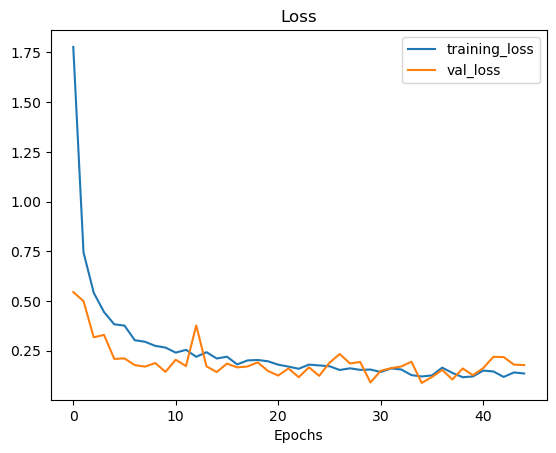

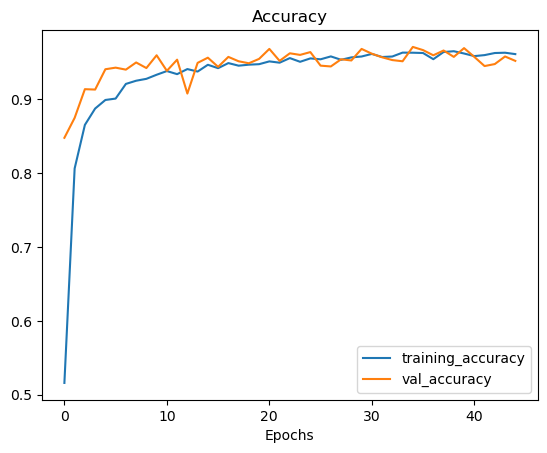

In [18]:
plot_loss_curves(history)

In [19]:
model.save('train_model_inceptionV3.h5')

C:\Users\Dany\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
history.history #Return Dictionary of history

{'loss': [1.777896761894226,
  0.7442326545715332,
  0.5406221747398376,
  0.4441261291503906,
  0.38222044706344604,
  0.3757907450199127,
  0.30242645740509033,
  0.29448840022087097,
  0.2738185524940491,
  0.2652272582054138,
  0.23983168601989746,
  0.253792405128479,
  0.21879300475120544,
  0.24200879037380219,
  0.21023821830749512,
  0.21925538778305054,
  0.18058454990386963,
  0.20053133368492126,
  0.20282264053821564,
  0.1963060200214386,
  0.17911680042743683,
  0.16941817104816437,
  0.15872621536254883,
  0.17947036027908325,
  0.1754576563835144,
  0.17134274542331696,
  0.1524592638015747,
  0.1609245240688324,
  0.15306170284748077,
  0.15482746064662933,
  0.14211636781692505,
  0.16018012166023254,
  0.15518848598003387,
  0.12673939764499664,
  0.11989913880825043,
  0.12512053549289703,
  0.16411134600639343,
  0.13761666417121887,
  0.116093710064888,
  0.11997468769550323,
  0.149427130818367,
  0.1450193226337433,
  0.11740650236606598,
  0.1401340514421463,


In [21]:
#Recording History in json
import json
with open('train_hist_inceptionv3.json','w') as f:
  json.dump(history.history,f)

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 95.19698023796082 %


In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

33/33 [==============================] - 38s 1s/step
The first 5 predictions: ['kayu manis', 'lada', 'cengkeh', 'jahe', 'kayu manis']


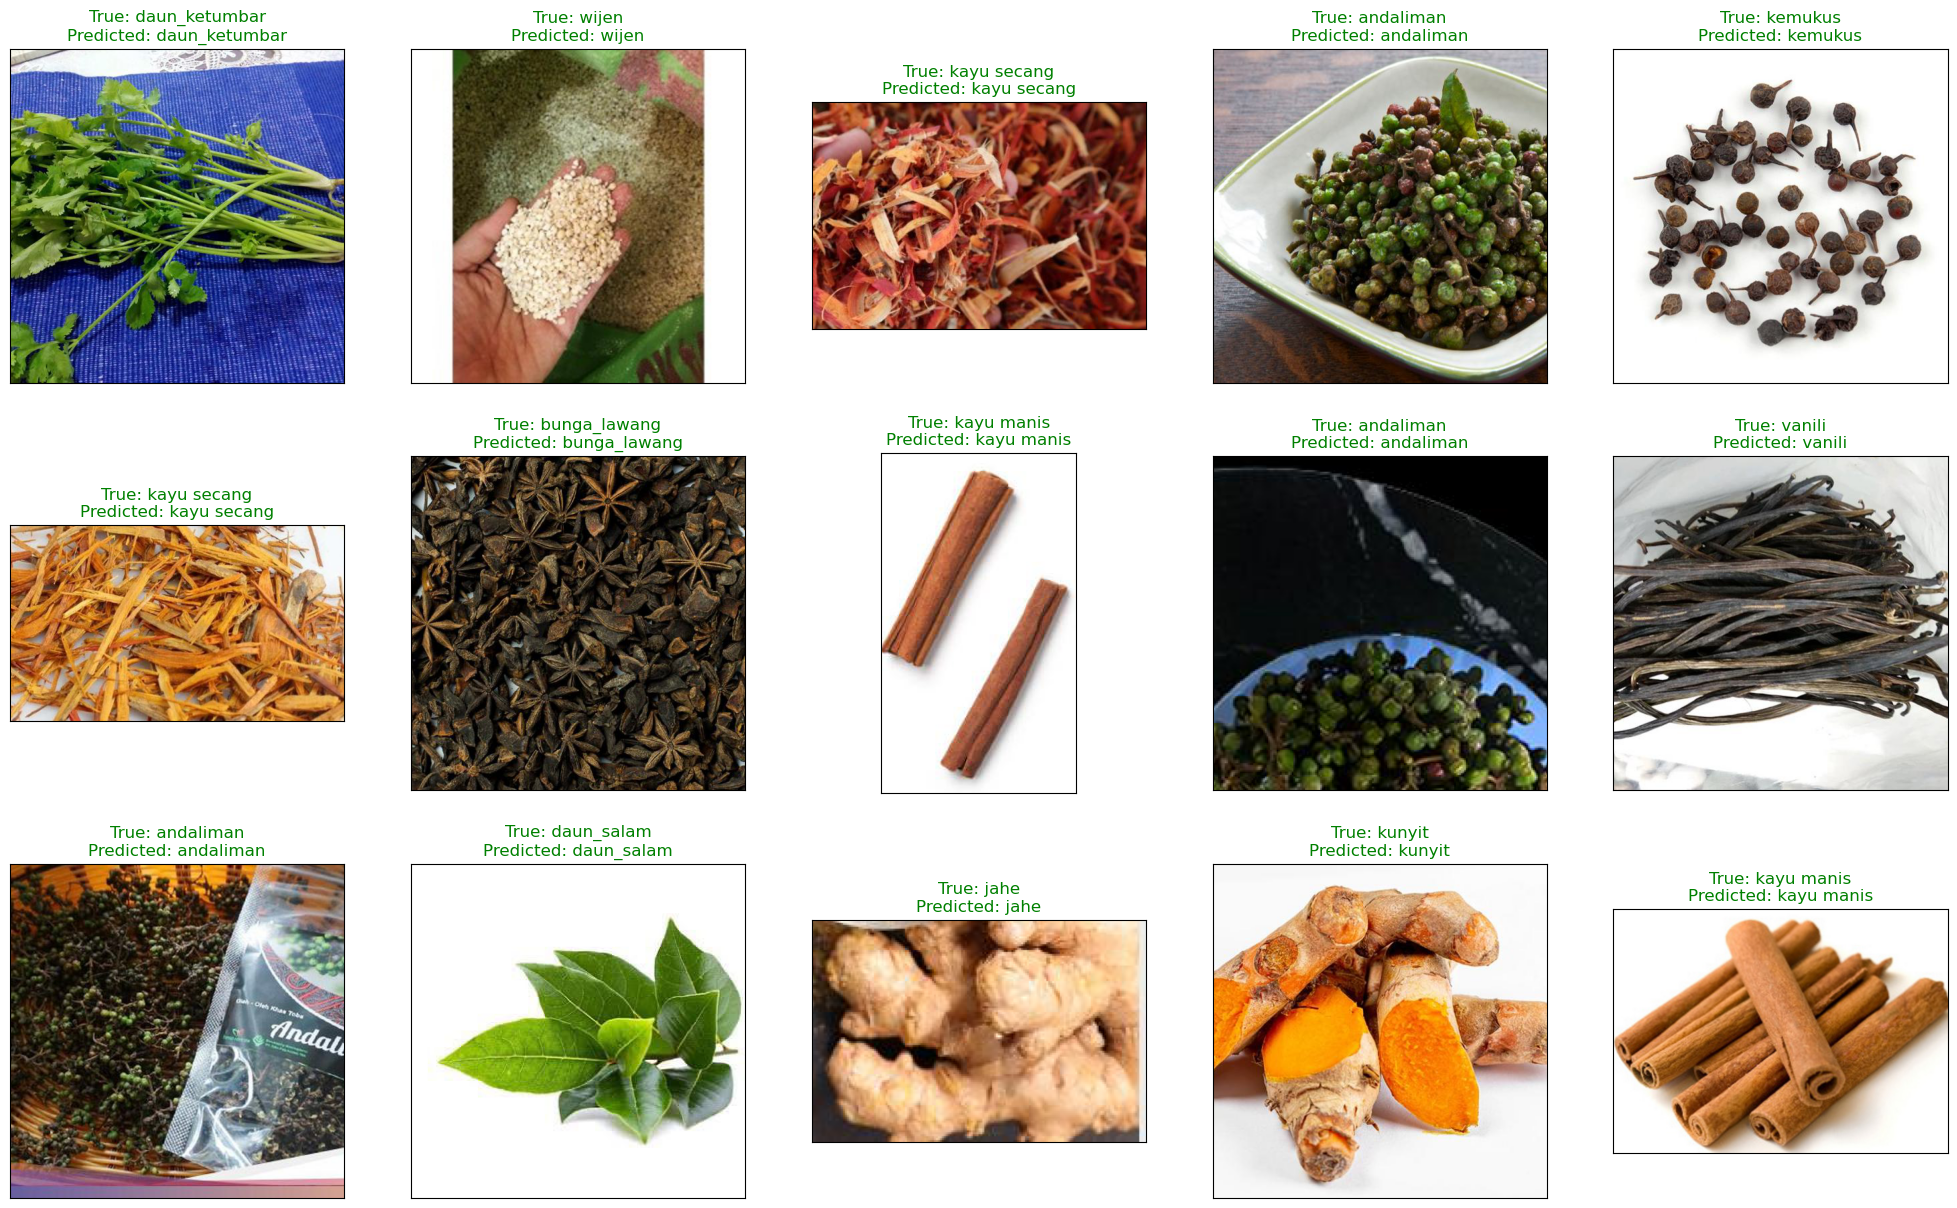

<Figure size 640x480 with 0 Axes>

In [27]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [26]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       0.97      1.00      0.99        35
    andaliman       1.00      1.00      1.00        42
    asam_jawa       1.00      1.00      1.00        41
biji_ketumbar       0.96      1.00      0.98        46
 bukan_rempah       1.00      0.97      0.99        37
 bunga_lawang       1.00      1.00      1.00        44
      cengkeh       1.00      0.96      0.98        45
daun_ketumbar       0.97      1.00      0.99        36
   daun_salam       1.00      0.84      0.91        37
         jahe       0.95      0.95      0.95        43
       jinten       0.91      1.00      0.95        29
     kapulaga       0.95      0.98      0.96        42
   kayu manis       0.95      0.90      0.93        42
  kayu secang       0.97      1.00      0.99        35
       kemiri       0.84      0.90      0.87        29
      kemukus       1.00      1.00      1.00        46
       kencur       0.88      0.90      0.89        40
       kl